# Face Classification and Verification


# Step 1: Data Preparation

In [ ]:
# --- Mount Google Drive (required for Colab persistence) ---
from google.colab import drive
drive.mount('/content/drive')

# --- Config: where to persist data on Drive ---
import os, shutil, subprocess, sys, tarfile, zipfile

PERSIST_ROOT = "/content/drive/MyDrive/CV_resNET"  
os.makedirs(PERSIST_ROOT, exist_ok=True)

# unified entry: point /content/data to the persistent directory on Drive
if os.path.islink("/content/data") or os.path.exists("/content/data"):
    try:
        # try to clean up old links/directories (be cautious if it's a directory, only delete when it's empty)
        if os.path.islink("/content/data"):
            os.unlink("/content/data")
        elif not os.listdir("/content/data"):
            shutil.rmtree("/content/data")
    except Exception as e:
        print("Warning cleaning /content/data:", e)
os.symlink(PERSIST_ROOT, "/content/data", target_is_directory=True)

# --- Tools for fast download & decompression ---
!apt -y -qq install aria2 zstd >/dev/null

# === Put your GitHub Release asset URLs here (one or many) ===
ASSET_URLS = [
    "https://github.com/fumingyang-felix/Budgeted-Broadcast-Network-BBNet/releases/download/CV/CV-classification.zip",
]

TMP_DIR = "/tmp/artifacts"
os.makedirs(TMP_DIR, exist_ok=True)

def sh(cmd: str):
    print(">>", cmd)
    code = subprocess.call(cmd, shell=True)
    if code != 0:
        sys.exit(code)

def extract_to(path: str, dest: str):
    fname = os.path.basename(path)
    if fname.endswith((".tar.zst", ".tzst")):
        sh(f'unzstd -c "{path}" | tar -xf - -C "{dest}"')
    elif fname.endswith((".tar.gz", ".tgz", ".tar")):
        mode = "r:gz" if fname.endswith((".tar.gz", ".tgz")) else "r:"
        with tarfile.open(path, mode) as tf:
            tf.extractall(dest)
    elif fname.endswith(".zip"):
        sh(f'unzip -qo "{path}" -d "{dest}"')
    else:
        # non-compressed file: directly copy
        sh(f'cp -f "{path}" "{dest}/"')

# --- Download & extract each asset ---
for url in ASSET_URLS:
    fname = url.rsplit("/", 1)[-1]
    out_path = os.path.join(TMP_DIR, fname)
    sh(f'aria2c -q -x 16 -s 16 -k 1M -c -o "{fname}" "{url}" -d "{TMP_DIR}"')
    size_mb = os.path.getsize(out_path) / (1024*1024)
    print(f"Downloaded: {out_path}  ({size_mb:.1f} MB)")
    extract_to(out_path, "/content/data")

# --- Show where things landed ---
print("\n--- Data is persisted at:", PERSIST_ROOT, "---")
sh('ls -lah "/content/data" | head -n 200')
print("\nDrive free space:")
sh('df -h "/content/drive" | tail -n 1')

# Step 2: Libraries

In [ ]:
import os # file path
import gc # cuda out of memory
import glob
import wandb
from tqdm import tqdm
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchsummary import summary

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, resnet50, resnet101, resnet152

import warnings
warnings.filterwarnings("ignore")

# Step 3: Configration

In [ ]:
CONFIG = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 64,
    'lr': 0.005,
    'epochs': 20,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'scheduler': 'cosine'
}

# Step 4: Dataset

## Datasets and Dataloaders

In [ ]:
DATA_DIR    = "/content/data/11-785-s24-hw2p2-classification"
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

In [ ]:
# Data Transformation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.ToTensor()
])

class TestDataset(Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# Dataset
train_dataset = ImageFolder(TRAIN_DIR, transform = train_transforms)
valid_dataset = ImageFolder(VAL_DIR, transform = valid_transforms)
test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# Dataloader
train_loader = DataLoader(dataset=train_dataset,batch_size=CONFIG['batch_size'],shuffle=True,num_workers=4,pin_memory=True)
valid_loader = DataLoader(dataset=valid_dataset,batch_size=CONFIG['batch_size'],shuffle=False,num_workers=2)
test_loader = DataLoader(dataset=test_dataset,batch_size = CONFIG['batch_size'],shuffle=False,drop_last=False,num_workers=2)

## EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", CONFIG['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  64
Train batches        :  2188
Val batches          :  547


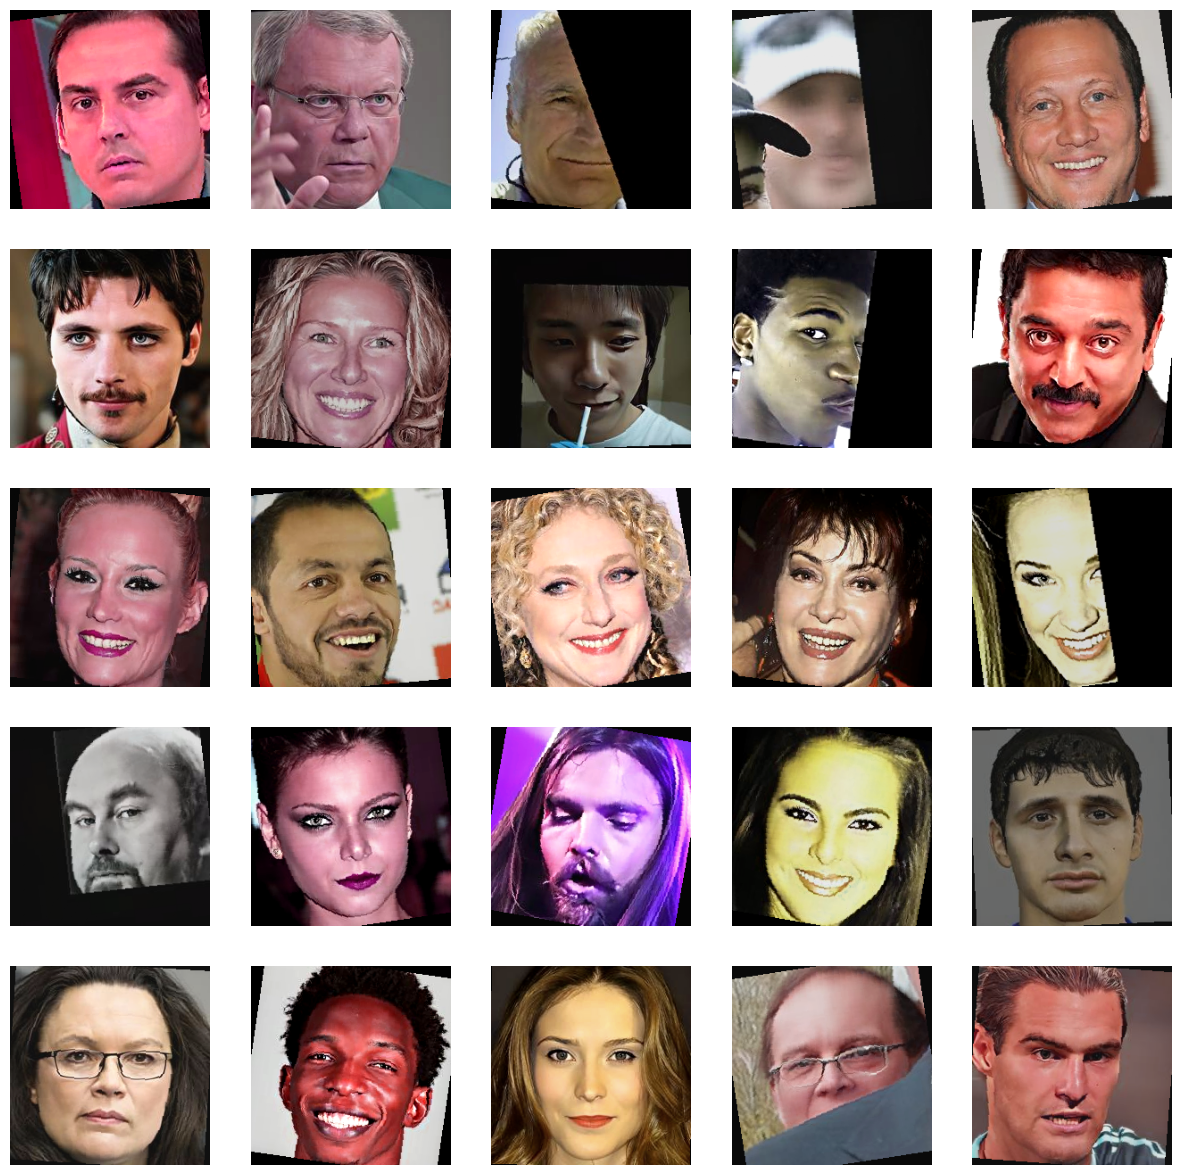

In [ ]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = DataLoader(
    dataset     = ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = CONFIG['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Step 5: Model

In [ ]:
# ==== Switch ====
USE_SP_IN = True   # False = Dense ResNet-101; True = SP-in

from torchvision.models import resnet101, ResNet101_Weights
import torch.nn.functional as F

# ---- SP-in configuration (warmup_steps will be set to absolute steps after getting train_loader)----
SP_CFG = dict(
    alpha=0.05,
    update_interval=200,
    warmup_steps=0,          # remember to use set_sp_warmup_steps(model, 5*len(train_loader))
    min_keep=8,
    rescale='sqrt',

    # === dynamic budget switch ===
    use_fixed_density=False,   # ← change to False
    busy_density=0.5,         # target retention rate for high-active channels (more tight)
    rare_density=0.9,         # target retention rate for low-active channels (more wide)
    tau_low=0.9,               # low-active threshold (EMA based on |z|-mean, ≈1)
    tau_high=1.1,              # high-active threshold
    auto_threshold=True,       # optional: use quantile to re-estimate tau (see below)
    q_low=0.30,                # low/high quantiles when auto_threshold
    q_high=0.70,

    prune_only=True,          # dynamic budget allows "grow back", otherwise high→low budget will take effect, low→high will not
)
class SPInConvBNReLU(nn.Module):
    def __init__(self, conv: nn.Conv2d, bn: nn.BatchNorm2d, relu: nn.Module, cfg: dict):
        super().__init__()
        self.conv, self.bn, self.relu = conv, bn, relu
        self.cfg = cfg
        Cout, Cin = conv.out_channels, conv.in_channels
        self.register_buffer('mask', torch.ones(Cout, Cin))
        self.register_buffer('activity_ema', torch.zeros(Cout))
        self.register_buffer('step', torch.zeros((), dtype=torch.long), persistent=False)
        self._next_mask = None   # ← delayed effect: replace at the beginning of next forward

    @torch.no_grad()
    def _update_activity(self, h):  # after BN+ReLU, [B,C,H,W]
        mu  = h.mean(dim=(0,2,3), keepdim=True)
        std = h.std (dim=(0,2,3), keepdim=True, unbiased=False).clamp_min(1e-6)
        a = ((h - mu)/std).abs().mean(dim=(0,2,3))   # [C]
        self.activity_ema.mul_(1 - self.cfg['alpha']).add_(self.cfg['alpha'] * a)

    @torch.no_grad()
    def _compute_density_vec(self):
        """
        return the target density density_i ∈ [busy_density, rare_density] for each output channel.
        rule: higher activity → tighter (closer to busy_density); lower activity → wider (closer to rare_density).
        linearly interpolate between [tau_low, tau_high]; saturate outside the interval.
        """
        C = self.cfg
        a = self.activity_ema.clone()

        # optional: use quantile to estimate threshold, avoid manual calibration (more stable in later training)
        if C.get('auto_threshold', False):
            # need non-zero samples; otherwise fall back to static tau
            if (a.numel() > 10) and (a.max() > 0):
                tl = torch.quantile(a, C.get('q_low', 0.3), interpolation='linear')
                th = torch.quantile(a, C.get('q_high', 0.7), interpolation='linear')
                tau_low, tau_high = float(tl.item()), float(th.item())
            else:
                tau_low, tau_high = float(C['tau_low']), float(C['tau_high'])
        else:
            tau_low, tau_high = float(C['tau_low']), float(C['tau_high'])

        rare_d  = float(C['rare_density'])
        busy_d  = float(C['busy_density'])
        # linear interpolation: norm=0 → rare_d; norm=1 → busy_d
        # clamp to [0,1]
        if tau_high <= tau_low + 1e-6:
            norm = torch.zeros_like(a)
        else:
            norm = (a - tau_low) / (tau_high - tau_low)
            norm = norm.clamp_(0.0, 1.0)
        dens = rare_d + (busy_d - rare_d) * norm
        return dens.clamp(min=0.0, max=1.0)  # [Cout]

    @torch.no_grad()
    def _maybe_update_mask(self):
        s = int(self.step.item())
        if s < int(self.cfg['warmup_steps']): return
        if self.cfg['update_interval'] <= 0 or (s % int(self.cfg['update_interval']) != 0): return

        W = self.conv.weight.detach()                   # [Cout,Cin,k,k]
        scores = W.abs().sum(dim=(2,3))                 # magnitude score for each fan-in
        cur = self.mask
        Cout, Cin = scores.size(0), scores.size(1)

        # —— dynamic budget: one density per row —— #
        if self.cfg.get('use_fixed_density', True):
            dens_vec = torch.full((Cout,), float(self.cfg['target_density']),
                                  device=scores.device, dtype=scores.dtype)
        else:
            dens_vec = self._compute_density_vec().to(scores.device, scores.dtype)

        new_mask = torch.zeros_like(cur)
        prune_only = bool(self.cfg.get('prune_only', False))

        for i in range(Cout):
            k_row = max(self.cfg['min_keep'], int(round(Cin * float(dens_vec[i]))))
            if prune_only:
                alive = cur[i].bool()                   # only select from alive (no grow back)
            else:
                alive = torch.ones_like(cur[i], dtype=torch.bool)  # allow grow back

            cand = scores[i][alive]
            if cand.numel() <= k_row:
                # not enough to Top-K, try to keep as many as possible
                row = new_mask[i]
                row[alive] = 1.0
                continue

            thr = cand.topk(k_row, largest=True).values[-1]
            row = new_mask[i]; row.zero_()
            # select in original space
            select = (scores[i] >= thr) & alive
            row[select] = 1.0

        # —— don't modify self.mask in place, replace at the beginning of next forward —— #
        self._next_mask = new_mask.to(self.mask.device, dtype=self.mask.dtype).detach()

    def forward(self, x):
        # apply the "new mask" computed in the previous forward
        if self._next_mask is not None:
            self.mask = self._next_mask
            self._next_mask = None

        # masked conv (rescale before BN)
        Wm = self.conv.weight * self.mask[:, :, None, None]
        pre = F.conv2d(x, Wm, bias=self.conv.bias, stride=self.conv.stride,
                       padding=self.conv.padding, dilation=self.conv.dilation, groups=self.conv.groups)

        if self.cfg['rescale'] != 'none':
            kept = self.mask.sum(dim=1).clamp_min(1.0)    # [Cout]
            if self.cfg['rescale'] == 'sqrt':
                scale = (float(self.conv.in_channels)/kept).sqrt()
            else:
                scale = (float(self.conv.in_channels)/kept)
            pre = pre * scale.to(pre.device, pre.dtype).view(1, -1, 1, 1)

        y = self.bn(pre)
        y = F.relu(y, inplace=False)

        if self.training:
            self._update_activity(y)
            self.step += 1
            self._maybe_update_mask()

        return y
# --- run this AFTER defining SPInConvBNReLU, BEFORE building the model ---

import types, torchvision
import torch.nn.functional as F
from torch import nn

def patch_resnet101_sp_in(model: nn.Module, sp_cfg: dict, stages=('layer3','layer4')):
    """
    replace conv1→bn1→relu in the bottleneck block of torchvision ResNet-101
    with SPInConvBNReLU(conv1, bn1, relu, sp_cfg).
    other layers remain unchanged; forward is modified to non-inplace add/relu to avoid autograd error.
    """
    Bottleneck = torchvision.models.resnet.Bottleneck

    def wrap_block(block: Bottleneck):
        # save original conv1/bn1/relu, and replace with our wrapped module
        conv1, bn1, relu = block.conv1, block.bn1, block.relu
        block.conv1 = nn.Identity()
        block.bn1   = nn.Identity()
        block.relu  = nn.Identity()
        block.sp1   = SPInConvBNReLU(conv1, bn1, relu, sp_cfg)

        # safe forward (non-inplace)
        def new_forward(self, x):
            identity = x

            out = self.sp1(x)                           # ← SP-in replaces conv1→bn1→relu
            out = self.conv2(out); out = self.bn2(out); out = F.relu(out, inplace=False)
            out = self.conv3(out); out = self.bn3(out)

            if self.downsample is not None:
                identity = self.downsample(x)

            out = out + identity                        # non-inplace add
            out = F.relu(out, inplace=False)            # non-inplace ReLU
            return out

        block.forward = types.MethodType(new_forward, block)
        return block

    # wrap each bottleneck in the specified stage (usually layer3/4)
    for name in stages:
        layer = getattr(model, name)
        for i, b in enumerate(layer):
            if isinstance(b, Bottleneck):
                layer[i] = wrap_block(b)
    return model


# ---- build model (only ResNet-101; your Network remains in the file, but not instantiated)----
# model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)  # equivalent to pretrained=True
# if USE_SP_IN:
#     model = patch_resnet101_sp_in(model, SP_CFG, stages=('layer3','layer4'))  # only modify middle/later layers, keep first two layers conservative
# model.fc = nn.Linear(model.fc.in_features, 7001)
# model = model.to(CONFIG['device'])
# summary(model, (3, 224, 224))

# ---- build model (only ResNet-101; your Network remains in the file, but not instantiated)----
model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
if USE_SP_IN:
    model = patch_resnet101_sp_in(model, SP_CFG, stages=('layer1','layer2','layer3','layer4'))
model.fc = nn.Linear(model.fc.in_features, 7001)
model = model.to(CONFIG['device'])
summary(model, (3, 224, 224))


# (optional) a convenient function: set warmup steps after getting train_loader
def set_sp_warmup_steps(model, warmup_steps:int):
    for m in model.modules():
        if isinstance(m, SPInConvBNReLU):
            m.cfg['warmup_steps'] = int(warmup_steps)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 216MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
    SPInConvBNReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9          [-1, 256, 56, 56]          16,384
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
       Bottleneck-13          [-1, 256, 56, 56]               0
      BatchNorm2d-14           [-1, 64,

In [ ]:
# call these two utility functions immediately after building model (and patch_resnet101_sp_in)

import types, torchvision
import torch.nn.functional as F

def disable_inplace_relu(model: nn.Module):
    # disable inplace ReLU for all layers
    for m in model.modules():
        if isinstance(m, nn.ReLU):
            m.inplace = False

def patch_bottleneck_safe_forward(model: nn.Module, layers=('layer1','layer2'), also_layers_34_when_dense=False):
    # replace bottleneck forward with safe forward (non-inplace)
    Bottleneck = torchvision.models.resnet.Bottleneck

    def safe_forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = F.relu(out, inplace=False)
        out = self.conv2(out); out = self.bn2(out); out = F.relu(out, inplace=False)
        out = self.conv3(out); out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out = out + identity               # non-inplace add
        out = F.relu(out, inplace=False)   # non-inplace ReLU
        return out

    use_layers = list(layers)
    if also_layers_34_when_dense:
        use_layers += ['layer3', 'layer4']

    for name in use_layers:
        layer = getattr(model, name)
        for b in layer:
            # only replace if it's a torchvision Bottleneck
            # in patch_bottleneck_safe_forward, replace this line
            # if isinstance(b, Bottleneck):
            # with ↓↓↓
            if isinstance(b, Bottleneck) and not hasattr(b, 'sp1'):
                b.forward = types.MethodType(safe_forward, b)


# ---- your original build process ----
# model = resnet101(...)
# if USE_SP_IN: model = patch_resnet101_sp_in(model, SP_CFG, stages=('layer3','layer4'))
# model.fc = ...

# 1) disable inplace ReLU for all layers
disable_inplace_relu(model)

# 2) layer1/2 use safe forward
#    if USE_SP_IN=False (dense comparison), set also_layers_34_when_dense=True, make 3/4 also use safe forward
patch_bottleneck_safe_forward(model, layers=('layer1','layer2'),
                              also_layers_34_when_dense=not USE_SP_IN)


In [ ]:
# # ===============================
# # A) slight enhancement: more robust SP mask update
# # ===============================
# # put this in your SPInConvBNReLU class, replace _maybe_update_mask() (other parts remain unchanged)
# @torch.no_grad()
# def _maybe_update_mask(self):
#     s = int(self.step.item())
#     if s < int(self.cfg['warmup_steps']):
#         return
#     itv = int(self.cfg['update_interval'])
#     if itv <= 0 or (s % itv) != 0:
#         return

#     W = self.conv.weight.detach()                   # [Cout,Cin,k,k]
#     scores = W.abs().sum(dim=(2,3))                 # magnitude score for each fan-in
#     cur = self.mask
#     Cout, Cin = scores.size(0), scores.size(1)

#     # —— dynamic budget (per-row density) ——
#     if self.cfg.get('use_fixed_density', True):
#         target_d = float(self.cfg.get('target_density', 0.5))
#         dens_vec = torch.full((Cout,), target_d, device=scores.device, dtype=scores.dtype)
#     else:
#         dens_vec = self._compute_density_vec().to(scores.device, scores.dtype)

#     new_mask = torch.zeros_like(cur, dtype=torch.float32)
#     prune_only = bool(self.cfg.get('prune_only', False))
#     min_keep = int(self.cfg.get('min_keep', 0))
#     min_keep = max(0, min_keep)

#     # —— robust Top-K (with ties handling) ——
#     for i in range(Cout):
#         # allow grow back in the whole row; only prune without grow back in the current alive
#         alive = cur[i].bool() if prune_only else torch.ones_like(cur[i], dtype=torch.bool)
#         Cin_alive = int(alive.sum().item())
#         k_row = max(min_keep, int(round(Cin * float(dens_vec[i]))))
#         k_row = min(k_row, Cin_alive)  # don't exceed the limit
#         if k_row <= 0:
#             continue

#         # sort only in candidates, break ties (add small increment bias)
#         cand_scores = scores[i][alive]
#         # for scores very close, prevent topk instability
#         epsilon = torch.linspace(0, 1e-7, cand_scores.numel(), device=cand_scores.device)
#         sort_idx = torch.argsort(cand_scores + epsilon, descending=True)
#         choose_local = sort_idx[:k_row]  # local index

#         # write back to original position
#         row = new_mask[i]
#         row[alive.nonzero(as_tuple=False).view(-1)[choose_local]] = 1.0

#     # —— delayed effect: replace at the beginning of next forward —— #
#     self._next_mask = new_mask.to(self.mask.device, dtype=self.mask.dtype).detach()


# # patch the function back to the class (if you already replaced it inside the class, you don't need these two lines)
# SPInConvBNReLU._maybe_update_mask = _maybe_update_mask


# # =====================================
# # B) sparsity statistics: edge-level & parameter-level (correct metric)
# # =====================================
# import pandas as pd
# import numpy as np

# @torch.no_grad()
# def collect_spin_stats(model: nn.Module, sp_class=SPInConvBNReLU):
#     rows = []
#     prunable_param_total = 0
#     prunable_param_alive = 0
#     kept_edges_all = 0
#     total_edges_all = 0

#     for name, m in (model.module if hasattr(model, "module") else model).named_modules():
#         if not isinstance(m, sp_class):
#             continue
#         mask = m.mask.detach().float().cpu()    # [Cout,Cin]
#         conv = getattr(m, "conv", None)
#         assert conv is not None, f"{name}: SP wrapper not found conv"
#         Cout, Cin = mask.shape

#         # group convolution (conv1 in ResNet-101 is groups=1, here for compatibility)
#         g = int(getattr(conv, "groups", 1))
#         if g == 1:
#             valid = torch.ones((Cout, Cin), dtype=torch.float32)
#         else:
#             out_gsz = Cout // g
#             in_gsz = Cin // g
#             out_gid = torch.arange(Cout) // out_gsz
#             in_gid  = torch.arange(Cin)  // in_gsz
#             valid = (out_gid[:, None] == in_gid[None, :]).to(torch.float32)

#         kept_edges = int((mask * valid).sum().item())
#         total_edges = int(valid.sum().item())
#         kept_per_out = (mask * valid).sum(dim=1).numpy()

#         k_elems = int(conv.weight[0,0].numel())   # number of kernel elements (1×1→1, 3×3→9)

#         layer_tag = 'layer3' if 'layer3' in name else ('layer4' if 'layer4' in name else 'other')
#         rows.append(dict(
#             module=name, layer=layer_tag, groups=g,
#             Cout=Cout, Cin=Cin, k_elems=k_elems,
#             kept_edges=kept_edges, total_edges=total_edges,
#             density= (kept_edges/total_edges) if total_edges>0 else None,
#             kept_mean=float(kept_per_out.mean()) if kept_per_out.size else 0.0,
#             kept_min=int(kept_per_out.min()) if kept_per_out.size else 0,
#             kept_max=int(kept_per_out.max()) if kept_per_out.size else 0,
#         ))

#         prunable_param_total += total_edges * k_elems
#         prunable_param_alive += kept_edges * k_elems
#         kept_edges_all += kept_edges
#         total_edges_all += total_edges

#     df = pd.DataFrame(rows)
#     if df.empty:
#         print("⚠️ SP-in module not found")
#         return dict(df=None)

#     def _agg(df_sub):
#         if df_sub.empty:
#             return dict(kept=0,total=0,density=None,sparsity=None)
#         kept = int(df_sub.kept_edges.sum()); total = int(df_sub.total_edges.sum())
#         dens = (kept/total) if total>0 else None
#         return dict(kept=kept,total=total,density=dens,sparsity=(1.0-dens) if dens is not None else None)

#     layer3 = _agg(df[df.layer=='layer3'])
#     layer4 = _agg(df[df.layer=='layer4'])
#     sp_overall_edges = dict(
#         kept=kept_edges_all, total=total_edges_all,
#         density=(kept_edges_all/total_edges_all) if total_edges_all>0 else None,
#         sparsity=(1.0 - kept_edges_all/total_edges_all) if total_edges_all>0 else None
#     )

#     sp_param_density = (prunable_param_alive/prunable_param_total) if prunable_param_total>0 else None
#     sp_overall_params = dict(
#         alive=prunable_param_alive, total=prunable_param_total,
#         density=sp_param_density, sparsity=(1.0-sp_param_density) if sp_param_density is not None else None
#     )

#     total_params = sum(p.numel() for p in (model.module if hasattr(model,"module") else model).parameters())
#     net_alive_params = total_params - (prunable_param_total - prunable_param_alive)
#     net_param_density = net_alive_params / total_params if total_params>0 else None
#     net_overall = dict(
#         alive=net_alive_params, total=total_params,
#         density=net_param_density, sparsity=(1.0-net_param_density) if net_param_density is not None else None
#     )

#     return dict(df=df, layer3=layer3, layer4=layer4,
#                 sp_overall_edges=sp_overall_edges,
#                 sp_overall_params=sp_overall_params,
#                 net_overall=net_overall)

# def print_spin_report(stats):
#     df = stats['df']
#     if df is None: return
#     def fmt_edge(d):
#         if d['density'] is None: return "N/A"
#         return f"density={d['density']*100:.2f}% | sparsity={(1-d['density'])*100:.2f}% | edges {d['kept']}/{d['total']}"
#     def fmt_param(d):
#         if d['density'] is None: return "N/A"
#         return f"density={d['density']*100:.2f}% | sparsity={d['sparsity']*100:.2f}% | params {d['alive']}/{d['total']}"

#     print("===== SP-in per-module (head) =====")
#     print(df[['module','layer','groups','Cout','Cin','k_elems','density','kept_mean','kept_min','kept_max']]
#           .head(12).to_string(index=False))
#     print("\n===== Edge-level summary =====")
#     print("Layer3:", fmt_edge(stats['layer3']))
#     print("Layer4:", fmt_edge(stats['layer4']))
#     print("SP-in overall (edges):", fmt_edge(stats['sp_overall_edges']))
#     print("\n===== Parameter-level summary =====")
#     print("SP-in prunable subset:", fmt_param(stats['sp_overall_params']))
#     print("Network overall:",      fmt_param(stats['net_overall']))


# # =========================================================
# # C) SP → structured channel pruning (Cin→Cmid → prune Cmid channels, get real speedup)
# #    - support mask count / usage_ema / weighted score three scoring modes
# #    - optional: remove SP wrapper, restore standard forward
# # =========================================================

# @torch.no_grad()
# def get_keep_idx_from_sp(sp_mod: nn.Module, keep_ratio=0.30, min_keep=16, score_mode="mask_count"):
#     """
#     extract the indices of Cmid channels to keep from the SP wrapper module (conv1).
#     score_mode:
#       - "mask_count": number of edges to keep per row (default, stable)
#       - "usage_ema": use activity EMA (if sp_mod.activity_ema)
#       - "weighted":   (mask * |W|_sum) row sum, more biased towards "strong connections"
#     """
#     mask = sp_mod.mask.detach().float().cpu()     # [Cmid, Cin]
#     Cmid = mask.size(0)
#     keep = max(min_keep, int(round(Cmid * float(keep_ratio))))
#     keep = min(keep, Cmid)

#     if score_mode == "usage_ema" and hasattr(sp_mod, "activity_ema"):
#         score = sp_mod.activity_ema.detach().float().cpu().view(-1)
#     elif score_mode == "weighted":
#         W = sp_mod.conv.weight.detach().abs().sum(dim=(2,3)).cpu()   # [Cmid,Cin]
#         score = (mask * W).sum(dim=1)
#     else:
#         score = mask.sum(dim=1)

#     topk = torch.topk(score, keep, largest=True).indices
#     keep_idx = torch.sort(topk).values.to(torch.long)
#     return keep_idx


# def _clone_bn(src_bn: nn.BatchNorm2d, new_C: int):
#     bn = nn.BatchNorm2d(new_C, eps=src_bn.eps, momentum=src_bn.momentum,
#                         affine=src_bn.affine, track_running_stats=src_bn.track_running_stats)
#     return bn

# @torch.no_grad()
# def prune_bottleneck_mid(block: nn.Module, keep_idx: torch.Tensor,
#                          sp_attr="sp1", conv2_attr="conv2", bn2_attr="bn2",
#                          conv3_attr="conv3", bn3_attr="bn3"):
#     """
#     slim down the middle channels on a single ResNet Bottleneck:
#       conv1(1x1) row pruning; bn1 sync pruning; conv2(3x3) row&col pruning; bn2 sync pruning;
#       conv3(1x1) col pruning; bn3 unchanged; downsample unchanged.
#     note: this function assumes block has been wrapped by patch_resnet101_sp_in(), SP module attribute named sp_attr.
#     """
#     device = next(block.parameters()).device
#     keep_idx = keep_idx.to(torch.long).cpu()

#     sp1 = getattr(block, sp_attr)
#     conv1 = sp1.conv; bn1 = sp1.bn
#     conv2 = getattr(block, conv2_attr); bn2 = getattr(block, bn2_attr)
#     conv3 = getattr(block, conv3_attr); bn3 = getattr(block, bn3_attr)

#     assert isinstance(conv2, nn.Conv2d) and int(conv2.groups) == 1, \
#         "This example only supports ResNet with 3x3 groups=1 (ResNeXt needs group-balanced pruning)"

#     Cin1, Cmid, Cout3 = conv1.in_channels, conv1.out_channels, conv3.out_channels
#     Ckeep = int(keep_idx.numel())

#     # conv1: row pruning
#     new_conv1 = nn.Conv2d(Cin1, Ckeep, kernel_size=1, stride=conv1.stride,
#                           padding=conv1.padding, dilation=conv1.dilation,
#                           bias=(conv1.bias is not None))
#     new_conv1.weight.copy_(conv1.weight.data[keep_idx, :, :, :])
#     if conv1.bias is not None:
#         new_conv1.bias.copy_(conv1.bias.data[keep_idx])

#     # bn1 sync pruning
#     new_bn1 = _clone_bn(bn1, Ckeep)
#     if bn1.affine:
#         new_bn1.weight.data.copy_(bn1.weight.data[keep_idx])
#         new_bn1.bias.data.copy_(bn1.bias.data[keep_idx])
#     if bn1.track_running_stats:
#         new_bn1.running_mean.data.copy_(bn1.running_mean.data[keep_idx])
#         new_bn1.running_var.data.copy_(bn1.running_var.data[keep_idx])

#     sp1.conv = new_conv1.to(device)
#     sp1.bn   = new_bn1.to(device)
#     # keep sp1.relu unchanged

#     # conv2: row&col pruning
#     new_conv2 = nn.Conv2d(Ckeep, Ckeep, kernel_size=conv2.kernel_size, stride=conv2.stride,
#                           padding=conv2.padding, dilation=conv2.dilation,
#                           bias=(conv2.bias is not None), groups=1)
#     new_conv2.weight.copy_(conv2.weight.data[keep_idx][:, keep_idx, :, :])
#     if conv2.bias is not None:
#         new_conv2.bias.copy_(conv2.bias.data[keep_idx])

#     new_bn2 = _clone_bn(bn2, Ckeep)
#     if bn2.affine:
#         new_bn2.weight.data.copy_(bn2.weight.data[keep_idx])
#         new_bn2.bias.data.copy_(bn2.bias.data[keep_idx])
#     if bn2.track_running_stats:
#         new_bn2.running_mean.data.copy_(bn2.running_mean.data[keep_idx])
#         new_bn2.running_var.data.copy_(bn2.running_var.data[keep_idx])

#     setattr(block, conv2_attr, new_conv2.to(device))
#     setattr(block, bn2_attr,   new_bn2.to(device))

#     # conv3: 列裁
#     new_conv3 = nn.Conv2d(in_channels=Ckeep, out_channels=Cout3, kernel_size=1, stride=conv3.stride,
#                           padding=conv3.padding, dilation=conv3.dilation, bias=(conv3.bias is not None))
#     new_conv3.weight.copy_(conv3.weight.data[:, keep_idx, :, :])
#     if conv3.bias is not None:
#         new_conv3.bias.copy_(conv3.bias.data)
#     setattr(block, conv3_attr, new_conv3.to(device))


# # optional: remove SP wrapper after pruning, restore standard forward (reduce inference overhead)
# import types
# def _install_standard_forward(block: nn.Module):
#     def std_forward(self, x):
#         identity = x
#         out = self.conv1(x); out = self.bn1(out); out = F.relu(out, inplace=False)
#         out = self.conv2(out); out = self.bn2(out); out = F.relu(out, inplace=False)
#         out = self.conv3(out); out = self.bn3(out)
#         if self.downsample is not None:
#             identity = self.downsample(x)
#         out = out + identity
#         out = F.relu(out, inplace=False)
#         return out
#     block.forward = types.MethodType(std_forward, block)

# @torch.no_grad()
# def drop_sp_wrapper(block: nn.Module, sp_attr="sp1"):
#     """
#     write back block.sp1(conv1/bn1/relu) to block.conv1/bn1/relu, and remove sp1, restore standard forward.
#     """
#     sp1 = getattr(block, sp_attr)
#     block.conv1 = sp1.conv
#     block.bn1   = sp1.bn
#     block.relu  = sp1.relu  # ReLU 保持非就地
#     delattr(block, sp_attr)
#     _install_standard_forward(block)


# @torch.no_grad()
# def prune_model_mid_from_sp(model: nn.Module, keep_ratio=0.30, min_keep=16,
#                             score_mode="mask_count", drop_wrappers=True):
#     """
#     traverse the entire network (after patch_resnet101_sp_in), for each bottleneck with sp1:
#       1) generate keep_idx based on SP's mask/usage
#       2) call prune_bottleneck_mid to prune Cmid
#       3) (optional) drop_sp_wrapper: remove wrapper, restore standard forward
#     """
#     m = model.module if hasattr(model, "module") else model
#     n_blocks, total_saved = 0, 0
#     for name, block in m.named_modules():
#         if not hasattr(block, "sp1") or not isinstance(block.sp1, SPInConvBNReLU):
#             continue
#         old_Cmid = int(block.sp1.conv.out_channels)
#         keep_idx = get_keep_idx_from_sp(block.sp1, keep_ratio=keep_ratio, min_keep=min_keep, score_mode=score_mode)
#         if keep_idx.numel() < old_Cmid:
#             prune_bottleneck_mid(block, keep_idx)
#             if drop_wrappers:
#                 drop_sp_wrapper(block)
#             n_blocks += 1
#             total_saved += (old_Cmid - int(keep_idx.numel()))
#     print(f"[prune] pruned {n_blocks} blocks; total mid-channels saved: {total_saved}")
#     return model


# # BN recalibration (strongly recommended after structured pruning)
# @torch.no_grad()
# def bn_recalibrate(model: nn.Module, data_iter, steps=200, device=None):
#     """
#     用若干 mini-batches 只跑前向，刷新 BN 的 running_mean/var。
#     data_iter: 可迭代 (x, y)；可用 iter(train_loader)
#     """
#     mdl = model.module if hasattr(model,"module") else model
#     was_training = mdl.training
#     mdl.train()
#     device = device or next(mdl.parameters()).device
#     it = iter(data_iter)
#     for _ in range(steps):
#         try:
#             xb, _ = next(it)
#         except StopIteration:
#             it = iter(data_iter); xb, _ = next(it)
#         xb = xb.to(device, non_blocking=True)
#         _ = mdl(xb)
#     if not was_training:
#         mdl.eval()


# # convenient: set warmup steps based on data size
# def set_sp_warmup_steps(model, warmup_steps:int):
#     for m in (model.module if hasattr(model, "module") else model).modules():
#         if isinstance(m, SPInConvBNReLU):
#             m.cfg['warmup_steps'] = int(warmup_steps)


In [ ]:
# class Network(nn.Module):
#     def __init__(self, num_classes=7001):
#         super(Network, self).__init__()

#         self.backbone = nn.Sequential(
#             # First layer
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=4, padding=3),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             # Second layer
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             # Third layer
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             # Fourth layer
#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             # Fifth layer
#             nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(1024),
#             nn.ReLU(inplace=True),
#             # Adaptive Average Pooling
#             nn.AdaptiveAvgPool2d((1, 1))
#         )

#         self.flatten = nn.Flatten()

#         self.cls_layer = nn.Sequential(
#             nn.Dropout(p=0.5),
#             nn.Linear(1024, 2048),
#             nn.ReLU(inplace=True),


#             nn.Linear(2048, num_classes),
#         )
#     def forward(self, x, return_feats=False):
#         feats = self.backbone(x)
#         feats = self.flatten(feats)
#         out = self.cls_layer(feats)

#         if return_feats:
#             return feats
#         else:
#             return out


# # Initialize your model
# model = Network().to(CONFIG['device'])
# summary(model, (3, 224, 224))

# Step 6: Loss, Optimizer, and Scheduler Definition

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=CONFIG['lr'], momentum=CONFIG['momentum'], weight_decay=CONFIG['weight_decay'])
# optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)
scaler = torch.cuda.amp.GradScaler()

# Step 7: Training and Validation Functions

## Classification Task

In [ ]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(CONFIG['device']), labels.to(CONFIG['device'])

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (CONFIG['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (CONFIG['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [ ]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(CONFIG['device']), labels.to(CONFIG['device'])

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (CONFIG['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (CONFIG['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

## Verification Task

In [ ]:
# This obtains the list of known identities from the known folder
known_regex = "/content/data/11-785-s24-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

print(f"unknown_dev_images shape: {unknown_dev_images.shape}")
print(f"unknown_test_images shape: {unknown_test_images.shape}")
print(f"known_images shape: {known_images.shape}")
# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= -1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 15490.30it/s]


unknown_dev_images shape: torch.Size([360, 3, 224, 224])
unknown_test_images shape: torch.Size([720, 3, 224, 224])
known_images shape: torch.Size([960, 3, 224, 224])


In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= CONFIG['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size
        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(CONFIG['device'])) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()
    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(CONFIG['device']))

        known_feats.append(known_feat)
        batch_bar.update()
    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()

    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    threshold = 0.45 # Choose a proper threshold
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv('/content/data/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Step 8: Wandb

In [ ]:
wandb.login(key="enter your wandb api key here") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ahearnyang (ahearnyang-harvard-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "enter your wandb run name", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "CV_resNET", ### Project should be created in your wandb account
    config = CONFIG ### Wandb Config for your run
)

# Step 9: Experiments

In [ ]:
best_class_acc = 0.0
best_ver_acc = 0.0

for epoch in range(CONFIG['epochs']):
    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, CONFIG['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, CONFIG['batch_size'], mode='val')
    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    scheduler.step(val_loss)

    # Save the best model
    if val_acc >= best_class_acc:
        best_valid_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification.pth')
        wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification.pth')
      wandb.save('checkpoint_verification.pth')
      print("Saved verification model")

# Finish wandb run
run.finish()




Epoch 1/20: 
Train Acc (Classification) 0.2828%	 Train Loss (Classification) 8.3333	 Learning Rate 0.0050


Val Acc (Classification) 1.2311%	 Val Loss (Classification) 7.3664


Val Acc (Verification) 5.8333%	 
Saved best classification model
Saved verification model



Epoch 2/20: 
Train Acc (Classification) 4.0941%	 Train Loss (Classification) 6.7058	 Learning Rate 0.0050


Val Acc (Classification) 9.6121%	 Val Loss (Classification) 5.9402


Val Acc (Verification) 14.4444%	 
Saved best classification model
Saved verification model



Epoch 3/20: 
Train Acc (Classification) 14.6245%	 Train Loss (Classification) 5.5192	 Learning Rate 0.0050


Val Acc (Classification) 20.8067%	 Val Loss (Classification) 5.1389


Val Acc (Verification) 15.5556%	 
Saved best classification model
Saved verification model



Epoch 4/20: 
Train Acc (Classification) 29.2319%	 Train Loss (Classification) 4.6495	 Learning Rate 0.0050


Val Acc (Classification) 35.0177%	 Val Loss (Classification) 4.3859


Val Acc (Verification) 22.7778%	 
Saved best classification model
Saved verification model



Epoch 5/20: 
Train Acc (Classification) 43.4372%	 Train Loss (Classification) 3.9740	 Learning Rate 0.0050


Val Acc (Classification) 45.4553%	 Val Loss (Classification) 3.8859


Val Acc (Verification) 25.5556%	 
Saved best classification model
Saved verification model



Epoch 6/20: 
Train Acc (Classification) 55.4952%	 Train Loss (Classification) 3.4603	 Learning Rate 0.0050


Val Acc (Classification) 52.5937%	 Val Loss (Classification) 3.5874


Val Acc (Verification) 32.7778%	 
Saved best classification model
Saved verification model



Epoch 7/20: 
Train Acc (Classification) 64.8537%	 Train Loss (Classification) 3.0723	 Learning Rate 0.0050


Val Acc (Classification) 57.0527%	 Val Loss (Classification) 3.4006


Val Acc (Verification) 33.3333%	 
Saved best classification model
Saved verification model



Epoch 8/20: 
Train Acc (Classification) 72.2621%	 Train Loss (Classification) 2.7734	 Learning Rate 0.0050


Val Acc (Classification) 61.7573%	 Val Loss (Classification) 3.2021


Val Acc (Verification) 33.8889%	 
Saved best classification model
Saved verification model



Epoch 9/20: 
Train Acc (Classification) 77.5766%	 Train Loss (Classification) 2.5461	 Learning Rate 0.0050


Val Acc (Classification) 66.0535%	 Val Loss (Classification) 3.0349


Val Acc (Verification) 35.2778%	 
Saved best classification model
Saved verification model



Epoch 10/20: 
Train Acc (Classification) 82.0755%	 Train Loss (Classification) 2.3615	 Learning Rate 0.0050


Val Acc (Classification) 70.3411%	 Val Loss (Classification) 2.8605


Val Acc (Verification) 36.3889%	 
Saved best classification model
Saved verification model



Epoch 11/20: 
Train Acc (Classification) 85.4997%	 Train Loss (Classification) 2.2118	 Learning Rate 0.0050


Val Acc (Classification) 72.6577%	 Val Loss (Classification) 2.7670


Val Acc (Verification) 35.5556%	 
Saved best classification model



Epoch 12/20: 
Train Acc (Classification) 88.2091%	 Train Loss (Classification) 2.0899	 Learning Rate 0.0050


Val Acc (Classification) 73.3547%	 Val Loss (Classification) 2.7396


Val Acc (Verification) 36.3889%	 
Saved best classification model
Saved verification model



Epoch 13/20: 
Train Acc (Classification) 90.4800%	 Train Loss (Classification) 1.9886	 Learning Rate 0.0050


Val Acc (Classification) 73.7831%	 Val Loss (Classification) 2.7079


Val Acc (Verification) 37.2222%	 
Saved best classification model
Saved verification model



Epoch 14/20: 
Train Acc (Classification) 92.3325%	 Train Loss (Classification) 1.9018	 Learning Rate 0.0050


Val Acc (Classification) 75.4742%	 Val Loss (Classification) 2.6383


Val Acc (Verification) 36.3889%	 
Saved best classification model



Epoch 15/20: 
Train Acc (Classification) 93.6622%	 Train Loss (Classification) 1.8271	 Learning Rate 0.0050


Val Acc (Classification) 76.4854%	 Val Loss (Classification) 2.6120


Val Acc (Verification) 37.7778%	 
Saved best classification model
Saved verification model



Epoch 16/20: 
Train Acc (Classification) 95.0047%	 Train Loss (Classification) 1.7623	 Learning Rate 0.0050


Val Acc (Classification) 76.8996%	 Val Loss (Classification) 2.6006


Val Acc (Verification) 39.7222%	 
Saved best classification model
Saved verification model



Epoch 17/20: 
Train Acc (Classification) 96.1223%	 Train Loss (Classification) 1.7038	 Learning Rate 0.0050


Val Acc (Classification) 78.3707%	 Val Loss (Classification) 2.5295


Val Acc (Verification) 38.6111%	 
Saved best classification model



Epoch 18/20: 
Train Acc (Classification) 96.9021%	 Train Loss (Classification) 1.6592	 Learning Rate 0.0050


Val Acc (Classification) 78.3335%	 Val Loss (Classification) 2.5291


Val Acc (Verification) 39.4444%	 
Saved best classification model



Epoch 19/20: 
Train Acc (Classification) 97.5491%	 Train Loss (Classification) 1.6176	 Learning Rate 0.0050


Val Acc (Classification) 79.6218%	 Val Loss (Classification) 2.4896


Val Acc (Verification) 41.1111%	 
Saved best classification model
Saved verification model



Epoch 20/20: 
Train Acc (Classification) 98.1854%	 Train Loss (Classification) 1.5792	 Learning Rate 0.0050


Val Acc (Classification) 79.6447%	 Val Loss (Classification) 2.4872


Val Acc (Verification) 41.1111%	 
Saved best classification model
Saved verification model


learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_classification_acc,▁▁▂▃▄▅▆▆▇▇▇▇▇███████
train_classification_loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_classification_acc,▁▂▃▄▅▆▆▆▇▇▇▇▇███████
val_classification_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_verification_acc,▁▃▃▄▅▆▆▇▇▇▇▇▇▇▇█████
learning_rate,0.005
train_classification_acc,98.18541
train_classification_loss,1.57924
val_classification_acc,79.64465
val_classification_loss,2.48718


# Step 10: Save & Load Model

In [ ]:
model_save_name = 'resnet101_fan_in_ablation.pt'
path = F"/content/drive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)

In [ ]:
model_load_name = 'resnet101_fan_in_ablation.pt'
path = F"/content/drive/My Drive/{model_load_name}"
model.load_state_dict(torch.load(path))

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# if the class name is different, change it to the class name in your code
SP_CLASS = SPInConvBNReLU
@torch.no_grad()
def collect_spin_stats(model: nn.Module):
    rows = []
    for name, m in model.named_modules():
        if isinstance(m, SP_CLASS):
            mask = m.mask.detach().float().cpu()               # [Cout, Cin]
            kept_per_out = mask.sum(dim=1).numpy()
            kept_edges = int(mask.sum().item())
            total_edges = int(mask.numel())

            # identify the layer: layer1/2/3/4, otherwise mark as other
            layer_tag = next((f'layer{i}' for i in (1,2,3,4) if f'layer{i}' in name), 'other')

            rows.append(dict(
                module=name, layer=layer_tag,
                Cout=mask.size(0), Cin=mask.size(1),
                kept_edges=kept_edges, total_edges=total_edges,
                density=kept_edges/total_edges if total_edges else 0.0,
                kept_mean=float(kept_per_out.mean()),
                kept_min=int(kept_per_out.min()), kept_max=int(kept_per_out.max())
            ))

    df = pd.DataFrame(rows)
    if df.empty:
        print("⚠️ SP-in module not found (did you turn on USE_SP_IN or class name mismatch?)")
        return dict(df=None)

    # —— summarize by layer (automatically cover the layers that appear) ——
    per_layer = {}
    for layer_name, sub in df.groupby('layer'):
        kept = int(sub.kept_edges.sum())
        total = int(sub.total_edges.sum())
        dens = (kept/total) if total else None
        per_layer[layer_name] = dict(kept=kept, total=total,
                                     density=dens, sparsity=(None if dens is None else 1.0-dens))

    # —— SP-in covers overall (all layers with SP) ——
    kept_all = int(df.kept_edges.sum()); total_all = int(df.total_edges.sum())
    dens_all = kept_all/total_all
    spars_all = 1.0 - dens_all

    # —— overall parameter-level density (treat conv1 weights with mask=0 as truly pruned) ——
    total_params = sum(p.numel() for p in model.parameters())
    pruned_params = 0
    for _, m in model.named_modules():
        if isinstance(m, SP_CLASS):
            k2 = int(np.prod(getattr(m.conv, 'kernel_size', (1,1))))
            pruned_params += (m.mask.numel() - int(m.mask.sum().item())) * k2
    net_alive_params = total_params - pruned_params
    net_param_density = net_alive_params / total_params
    net_param_sparsity = 1.0 - net_param_density

    return dict(
        df=df,
        per_layer=per_layer,                       # <- dynamic layer-level statistics: layer1/2/3/4/other (if any)
        sp_overall=dict(kept=kept_all, total=total_all,
                        density=dens_all, sparsity=spars_all),
        net_overall=dict(alive=net_alive_params, total=total_params,
                         density=net_param_density, sparsity=net_param_sparsity)
    )

def print_spin_report(stats):
    df = stats['df']
    if df is None: return

    order = {'layer1':1, 'layer2':2, 'layer3':3, 'layer4':4, 'other':99}
    def fmt(d):
        if d['total']==0 or d['density'] is None: return "N/A"
        return f"density={d['density']*100:.2f}% | sparsity={d['sparsity']*100:.2f}% | edges {d['kept']}/{d['total']}"

    print("===== SP-in per-module (head) =====")
    print(df[['module','layer','Cout','Cin','density','kept_mean','kept_min','kept_max']]
          .head(10).to_string(index=False))

    print("\n===== Stage summary (by layer) =====")
    for layer_name, d in sorted(stats['per_layer'].items(), key=lambda kv: order.get(kv[0], 99)):
        print(f"{layer_name:>6}: {fmt(d)}")

    print("SP-in overall:", fmt(stats['sp_overall']))

    net = stats['net_overall']
    print("\n===== Network (parameter-level) =====")
    print(f"param density={net['density']*100:.2f}% | sparsity={net['sparsity']*100:.2f}% | params {net['alive']}/{net['total']}")

# —— usage: call anytime (e.g. at the end of each epoch) ——
stats = collect_spin_stats(model)
print_spin_report(stats)

# (optional) if you use wandb, you can also record easily:
try:
    import wandb, numpy as np
    if stats.get('df') is not None:
        df = stats['df']
        # histogram of "how many fan-in to keep per output channel" for each module (merged Layer3 & Layer4)
        kept_all = []
        for name, m in model.named_modules():
            if isinstance(m, SP_CLASS):
                kept_all.append(m.mask.sum(dim=1).detach().cpu().numpy())
        kept_all = np.concatenate(kept_all) if kept_all else np.array([])
        log_dict = {
            'sp/layer3_density': stats['layer3']['density'],
            'sp/layer4_density': stats['layer4']['density'],
            'sp/overall_density': stats['sp_overall']['density'],
            'net/param_density': stats['net_overall']['density'],
        }
        if kept_all.size:
            log_dict['sp/kept_per_out_hist'] = wandb.Histogram(kept_all)
        wandb.log(log_dict)
except Exception as e:
    pass


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# if the class name is different, change it to the class name in your code
SP_CLASS = SPInConvBNReLU

@torch.no_grad()
def collect_spin_stats(model: nn.Module):
    rows = []
    prunable_param_total = 0      # total number of parameters controlled by SP-in
    prunable_param_alive = 0      # number of parameters retained by mask
    kept_edges_all = 0
    total_edges_all = 0

    for name, m in model.named_modules():
        if not isinstance(m, SP_CLASS):
            continue

        # --- get mask and convolution kernel ---
        mask = m.mask.detach().to(torch.float32).cpu()    # [Cout, Cin] 0/1
        conv = getattr(m, "conv", None) or getattr(m, "conv2", None)
        assert conv is not None, f"{name}: conv not found (try changing the attribute name to conv/conv2)"

        Cout, Cin = mask.shape
        # number of parameters per valid "edge" (supports 1D/2D/3D convolutions)
        k_elems = int(conv.weight[0, 0].numel())

        # --- process the "valid" edge set of grouped convolutions ---
        g = int(getattr(conv, "groups", 1))
        if g == 1:
            valid = torch.ones((Cout, Cin), dtype=torch.float32)
        else:
            # group size (divisible assumption)
            out_gsz = Cout // g
            in_gsz  = Cin  // g
            out_gid = torch.arange(Cout) // out_gsz
            in_gid  = torch.arange(Cin)  // in_gsz
            valid = (out_gid[:, None] == in_gid[None, :]).to(torch.float32)  # [Cout,Cin]

        # count edges (only count valid ones)
        kept_edges = int((mask * valid).sum().item())
        total_edges = int(valid.sum().item())
        kept_per_out = (mask * valid).sum(dim=1).numpy()

        # —— record details (by module) ——
        layer_tag = 'layer3' if 'layer3' in name else ('layer4' if 'layer4' in name else 'other')
        rows.append(dict(
            module=name, layer=layer_tag,
            Cout=Cout, Cin=Cin, groups=g,
            kept_edges=kept_edges, total_edges=total_edges,
            density=kept_edges/total_edges if total_edges>0 else None,
            kept_mean=float(kept_per_out.mean()) if kept_per_out.size else 0.0,
            kept_min=int(kept_per_out.min()) if kept_per_out.size else 0,
            kept_max=int(kept_per_out.max()) if kept_per_out.size else 0,
            k_elems=k_elems,
        ))

        # —— parameter-level (only the part that SP-in can prune) ——
        prunable_param_total += total_edges * k_elems
        prunable_param_alive += kept_edges * k_elems
        kept_edges_all += kept_edges
        total_edges_all += total_edges

    df = pd.DataFrame(rows)
    if df.empty:
        print("⚠️ SP-in module not found (possibly not enabled or class name mismatch).")
        return dict(df=None)

    # —— layer-wise aggregation (weighted by "edges") ——
    def _agg(layer_name):
        sub = df[df.layer == layer_name]
        if sub.empty:
            return dict(kept=0, total=0, density=None, sparsity=None)
        kept = int(sub.kept_edges.sum())
        total = int(sub.total_edges.sum())
        dens = kept/total if total>0 else None
        return dict(kept=kept, total=total, density=dens, sparsity=(1.0-dens) if dens is not None else None)

    layer3 = _agg('layer3')
    layer4 = _agg('layer4')

    # —— SP-in covers overall (by "edges") ——
    sp_overall_edges = dict(
        kept=kept_edges_all,
        total=total_edges_all,
        density=(kept_edges_all/total_edges_all) if total_edges_all>0 else None,
        sparsity=(1.0 - kept_edges_all/total_edges_all) if total_edges_all>0 else None
    )

    # —— parameter-level sparsity on the "prunable parameter subset" (SP-in covers the convolution weights) ——
    sp_param_density = prunable_param_alive / prunable_param_total if prunable_param_total>0 else None
    sp_param_summary = dict(
        alive=prunable_param_alive, total=prunable_param_total,
        density=sp_param_density,
        sparsity=(1.0 - sp_param_density) if sp_param_density is not None else None
    )

    # —— overall parameter-level (treat weights with mask=0 as "invalid" parameters, deduct from total) ——
    total_params = sum(p.numel() for p in model.parameters())
    net_alive_params = total_params - (prunable_param_total - prunable_param_alive)
    net_param_density = net_alive_params / total_params if total_params>0 else None
    net_param_summary = dict(
        alive=net_alive_params, total=total_params,
        density=net_param_density,
        sparsity=(1.0 - net_param_density) if net_param_density is not None else None
    )

    return dict(
        df=df,
        layer3=layer3, layer4=layer4,
        sp_overall_edges=sp_overall_edges,   # density/sparsity based on "edges"
        sp_overall_params=sp_param_summary,  # density/sparsity on the "prunable parameter subset" (SP-in covers the convolution weights) ← most reflects mask strength
        net_overall=net_param_summary        # density/sparsity on the "overall" (treat weights with mask=0 as "invalid" parameters, deduct from total)
    )


def print_spin_report(stats):
    df = stats['df']
    if df is None: return
    def fmt(d):
        if d['total']==0 or d['density'] is None: return "N/A"
        return f"density={d['density']*100:.2f}% | sparsity={d['sparsity']*100:.2f}% | edges {d['kept']}/{d['total']}"
    print("===== SP-in per-module (head) =====")
    print(df[['module','layer','Cout','Cin','density','kept_mean','kept_min','kept_max']].head(10).to_string(index=False))
    print("\n===== Stage summary =====")
    print("Layer3:", fmt(stats['layer3']))
    print("Layer4:", fmt(stats['layer4']))
    print("SP-in overall (L3+L4):", fmt(stats['sp_overall']))
    net = stats['net_overall']
    print("\n===== Network (parameter-level) =====")
    print(f"param density={net['density']*100:.2f}% | sparsity={net['sparsity']*100:.2f}% | params {net['alive']}/{net['total']}")

# —— usage: call anytime (e.g. at the end of each epoch) ——
stats = collect_spin_stats(model)
print_spin_report(stats)

# (optional) if you use wandb, you can also record easily:
try:
    import wandb, numpy as np
    if stats.get('df') is not None:
        df = stats['df']
        # histogram of "how many fan-in to keep per output channel" for each module (merged Layer3 & Layer4)
        kept_all = []
        for name, m in model.named_modules():
            if isinstance(m, SP_CLASS):
                kept_all.append(m.mask.sum(dim=1).detach().cpu().numpy())
        kept_all = np.concatenate(kept_all) if kept_all else np.array([])
        log_dict = {
            'sp/layer3_density': stats['layer3']['density'],
            'sp/layer4_density': stats['layer4']['density'],
            'sp/overall_density': stats['sp_overall']['density'],
            'net/param_density': stats['net_overall']['density'],
        }
        if kept_all.size:
            log_dict['sp/kept_per_out_hist'] = wandb.Histogram(kept_all)
        wandb.log(log_dict)
except Exception as e:
    pass

